In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
movies = pd.read_csv('genre.csv')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  486 non-null    int64 
 1   title    486 non-null    object
 2   genres   486 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.5+ KB


In [ ]:
 
def extract_title(title):
   year = title[len(title)-5:len(title)-1]  
   if year.isnumeric():
      title_no_year = title[:len(title)-7]
      return title_no_year
   else:
      return title
def extract_year(title):
   year = title[len(title)-5:len(title)-1]
   if year.isnumeric():
      return int(year)
   else:
      return np.nan
movies.rename(columns={'title':'title_year'}, inplace=True) 
movies['title_year'] = movies['title_year'].apply(lambda x: x.strip()) 
movies['title'] = movies['title_year'].apply(extract_title) 
movies['year'] = movies['title_year'].apply(extract_year) 

In [ ]:
def extract_title(title):
   year = title[len(title)-5:len(title)-1] 
   if year.isnumeric():
      title_no_year = title[:len(title)-7]
      return title_no_year
   else:
      return title
def extract_year(title):
   year = title[len(title)-5:len(title)-1]
   if year.isnumeric():
      return int(year)
   else:
      return np.nan
movies.rename(columns={'title':'title_year'}, inplace=True) 
movies['title_year'] = movies['title_year'].apply(lambda x: x.strip()) 
movies['title'] = movies['title_year'].apply(extract_title) 
movies['year'] = movies['title_year'].apply(extract_year) 

In [ ]:
r,c = movies[movies['genres']=='(no genres listed)'].shape
print('The number of movies which do not have info about genres:',r)
movies = movies[~(movies['genres']=='(no genres listed)')].reset_index(drop=True)

The number of movies which do not have info about genres: 0


<ipython-input-32-dc0b315a999d>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['genres'] = movies['genres'].str.replace('|',' ')


Text(0, 0.5, 'Counts')

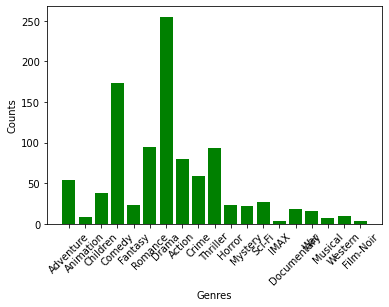

In [ ]:

movies['genres'] = movies['genres'].str.replace('|',' ')
counts = dict()
for i in movies.index:
   for g in movies.loc[i,'genres'].split(' '):
      if g not in counts:
         counts[g] = 1
      else:
         counts[g] = counts[g] + 1
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=45)
plt.xlabel('Genres')
plt.ylabel('Counts')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
movies['genres'] = movies['genres'].str.replace('Sci-Fi','SciFi')
movies['genres'] = movies['genres'].str.replace('Film-Noir','Noir')
tfidf_vector = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vector.fit_transform(movies['genres'])

In [ ]:
tfidf_matrix.shape


(486, 19)

In [ ]:
print(list(enumerate(tfidf_vector.get_feature_names())))

[(0, 'action'), (1, 'adventure'), (2, 'animation'), (3, 'children'), (4, 'comedy'), (5, 'crime'), (6, 'documentary'), (7, 'drama'), (8, 'fantasy'), (9, 'horror'), (10, 'imax'), (11, 'musical'), (12, 'mystery'), (13, 'noir'), (14, 'romance'), (15, 'scifi'), (16, 'thriller'), (17, 'war'), (18, 'western')]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.metrics.pairwise import linear_kernel
sim_matrix = linear_kernel(tfidf_matrix,tfidf_matrix) 
print(sim_matrix)

[[1.         0.75572094 0.15025974 ... 0.09574404 0.         0.24605568]
 [0.75572094 1.         0.         ... 0.         0.         0.        ]
 [0.15025974 0.         1.         ... 0.23762251 0.67115372 0.61067374]
 ...
 [0.09574404 0.         0.23762251 ... 1.         0.         0.38911532]
 [0.         0.         0.67115372 ... 0.         1.         0.        ]
 [0.24605568 0.         0.61067374 ... 0.38911532 0.         1.        ]]


In [ ]:
pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fuzzywuzzy import fuzz
def matching_score(a,b):
   return fuzz.ratio(a,b)

In [ ]:
def get_title_year_from_index(index):
   return movies[movies.index == index]['title_year'].values[0]
def get_title_from_index(index):
   return movies[movies.index == index]['title'].values[0]
def get_index_from_title(title):
   return movies[movies.title == title].index.values[0]
def find_closest_title(title):
   leven_scores = list(enumerate(movies['title'].apply(matching_score, b=title)))
   sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
   closest_title = get_title_from_index(sorted_leven_scores[0][0])
   distance_score = sorted_leven_scores[0][1]
   return closest_title, distance_score

In [ ]:
def contents_based_recommender(movie_user_likes, how_many):
   closest_title, distance_score = find_closest_title(movie_user_likes)
  
   if distance_score == 100:
      movie_index = get_index_from_title(closest_title)
      movie_list = list(enumerate(sim_matrix[int(movie_index)]))
     
      similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True))) 
      
      print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')
      for i,s in similar_movies[:how_many]:
         print(get_title_year_from_index(i))
   
   else:
      print('Did you mean '+'\033[1m'+str(closest_title)+'\033[0m'+'?','\n')
      movie_index = get_index_from_title(closest_title)
      movie_list = list(enumerate(sim_matrix[int(movie_index)]))
      similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True)))
      print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')
      for i,s in similar_movies[:how_many]:
         print(get_title_year_from_index(i))

In [ ]:
contents_based_recommender('Monsters, Inc.', 20)

Did you mean Dunston Checks In? 

Here's the list of movies similar to Dunston Checks In.

It Takes Two (1995)
Big Green, The (1995)
Heavyweights (Heavy Weights) (1995)
Richie Rich (1994)
Baby-Sitters Club, The (1995)
Now and Then (1995)
Babe (1995)
White Balloon, The (Badkonake sefid) (1995)
Fluke (1995)
Little Princess, A (1995)
Gordy (1995)
Flintstones, The (1994)
Addams Family Values (1993)
Mighty Morphin Power Rangers: The Movie (1995)
Tom and Huck (1995)
Amazing Panda Adventure, The (1995)
Casper (1995)
Far From Home: The Adventures of Yellow Dog (1995)
Lassie (1994)
Free Willy 2: The Adventure Home (1995)
